# Tutorial for using FateExplorer to analyze mouse hematopoiesis single-cell lineage tracing data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import Fate2Vec.tl.model as fe
from pkg_resources import resource_filename

## 1. Load larry dataset (in vitro) as example

In [2]:
### load test data
np.random.seed(114514)
data_path = resource_filename('Fate2Vec', 'data/larry_clone_ct.csv')
data = pd.read_csv(data_path,index_col=0)
data.index = data.index.astype(str)
data = data[data['HSPC'] != 0]
data = data[(data.drop(columns='HSPC') != 0).any(axis=1)]
data = data.drop(columns='HSPC')
print(data)

      Monocyte  Neutrophil  Baso  Erythroid  Meg  Mast  Lymphoid  Eos  \
394         33           1     0          0    0     0         0    0   
1972         0           0     4          0    0     1         0    0   
1450         6           5     0          0    0     0         0    0   
5624         9           0     0          0    0     0         0    0   
1652         0           4     0          0    0     0         0    0   
...        ...         ...   ...        ...  ...   ...       ...  ...   
3606         1           0     0          0    0     0         0    0   
646          1           0     0          0    0     0         0    0   
4384         1           0     0          0    0     0         0    0   
3623         0           1     0          0    0     0         0    0   
5378         1           0     0          0    0     0         0    0   

      Ccr7_DC  pDC  
394         0    0  
1972        0    0  
1450        0    0  
5624        0    0  
1652        0    0

## 2. Generate clone embedding based on skipgram method.

### Some key parameters (if you dont understand word2vec model, just use default)
'clone_size_thr': clone size threshold to filter clones (Small clone size clones are too sparse, thus contaminating model training. Additionally, these small clones generally have restricted fates, so you can manually define their fates) 

'cor_thr': spearman correlation threshold to tokenize clones 

'dims': output dimensions for clone embedding 

'window': word2vec window size

In [3]:
### embed clone
clone_embed = fe.Fate2Vec(data,ncores=25)
clone_embed.embed(clone_size_thr=3,cor_thr=0.2,dims=5,window=5,umap_min_dist=1)

Potential Multilineage clone number: 0


## 3. Unsupervise clustering to identify clone fate bias based on clone embedding

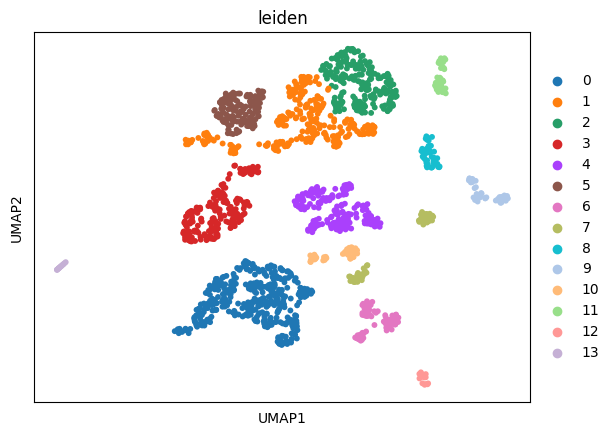

In [4]:
sc.tl.leiden(clone_embed.adata,resolution=0.1)
sc.pl.umap(clone_embed.adata,color='leiden')

## 4. Visualize clone contribution for each cell type

### There two methods to normalize contribution: 'ratio' and 'log10'. For single-cell lineage tracing data, we recommend 'ratio'. For bulk lineage tracing data, we recommed 'log10'

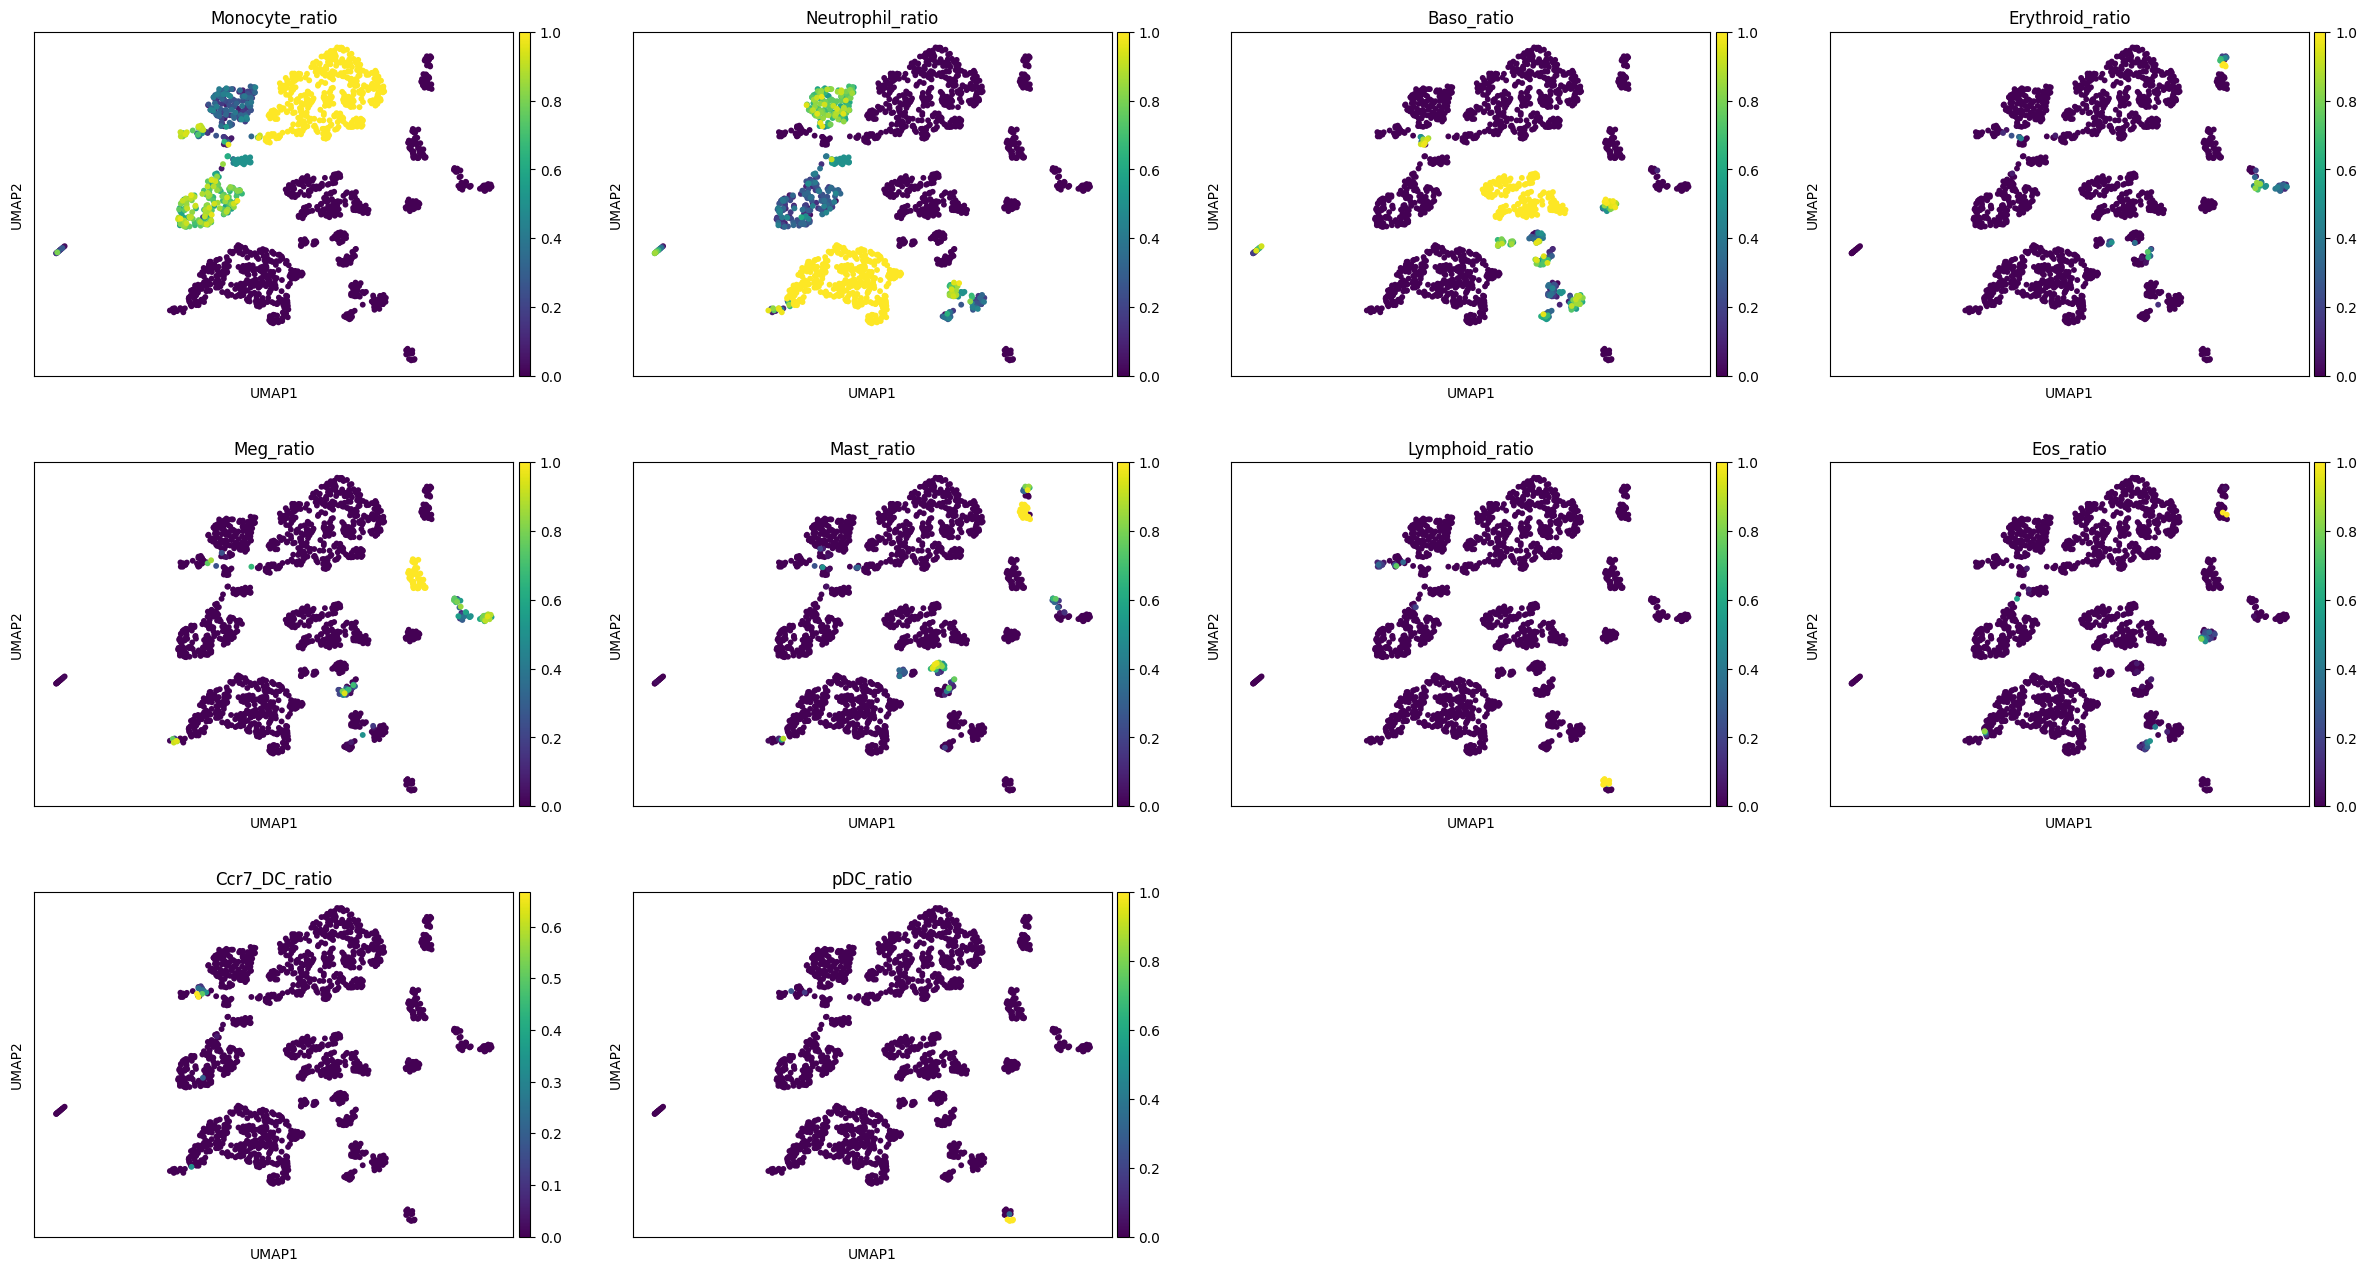

In [5]:
clone_embed.add_clone_contribution(normalize_method='ratio')
clone_embed.plot_clone_contribution(normalize_method='ratio')

## 5. Visualize clone contribution in each cluster

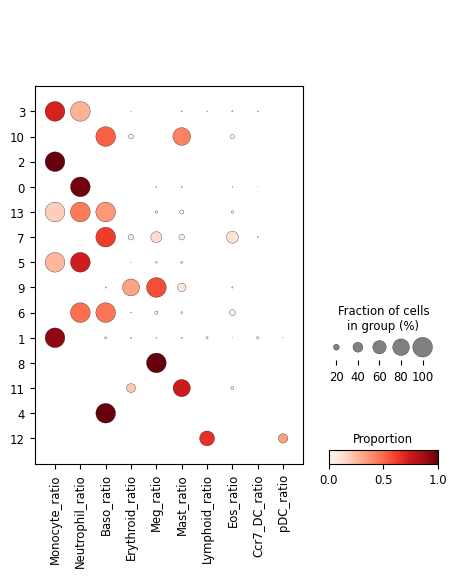

In [6]:
sc.pl.dotplot(clone_embed.adata, var_names=clone_embed.celltype_index, groupby='leiden', colorbar_title='Proportion', dendrogram=False)

## 6. Construct clone-level lineage tree based on clone embedding

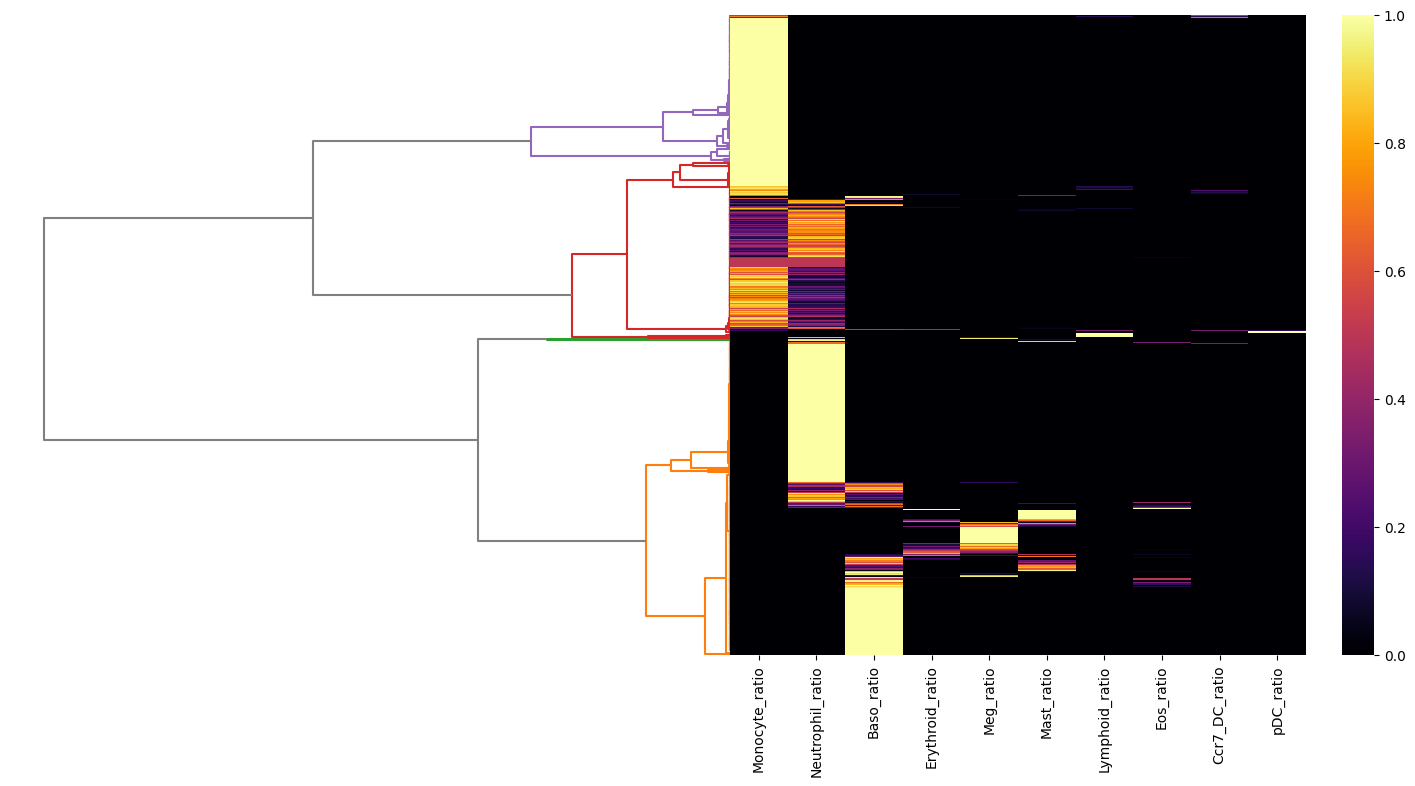

In [7]:
clone_embed.plot_dendrogram(tree_color_threshold=0.05)

## 7. Map fate cluster to original cell-level umap embedding

In this section, we provide function to help use to visualize fate cluster on the original cell embedding.

In [8]:
adata = sc.read_h5ad('/data/jiangjunyao/h5ad_0921/Weinreb_2020_Science.h5ad')
adata.obs['barcodes'] = adata.obs['barcodes'].astype(str)
adata = adata[adata.obs.barcodes.isin(clone_embed.adata.obs_names)]
umap_coordinates = adata.obs[['UMAP_1', 'UMAP_2']].to_numpy()
adata.obsm['X_umap'] = umap_coordinates
adata = clone_embed.map_fate_cell_manifold(adata)

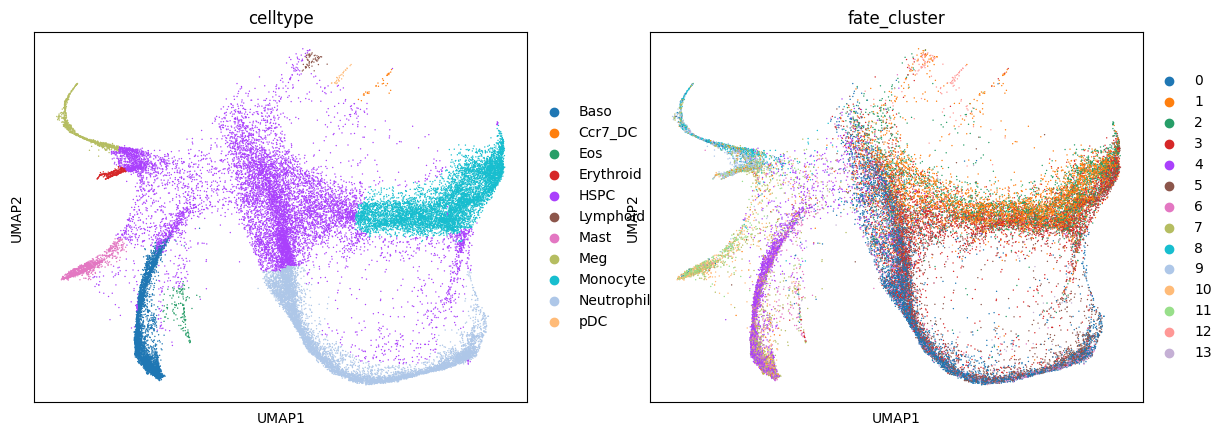

In [9]:
sc.pl.umap(adata,color=['celltype','fate_cluster'])

## 8. Integrate gene expression into clone embedding

In this section, we aggregate the expression data for each clone and compare the transcriptomic differences among clones with distinct fates.

In [10]:
sc.pp.log1p(adata)
adata_use = adata[adata.obs.celltype.isin(clone_embed.mt.columns)]
clone_embed.aggregate_clone_feature(adata_use)

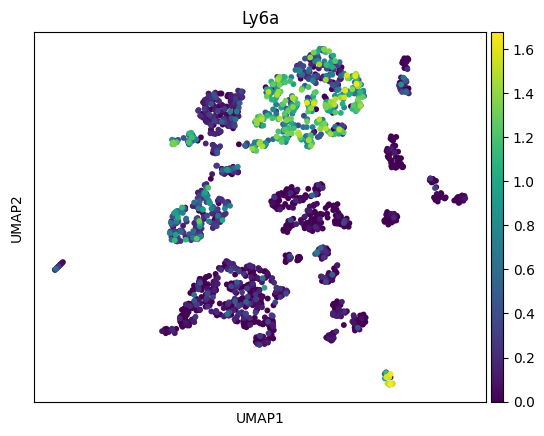

In [11]:
sc.pl.umap(clone_embed.adata,color='Ly6a')

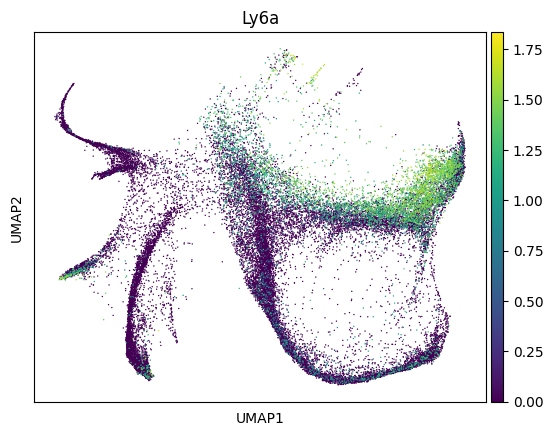

In [12]:
sc.pl.umap(adata,color='Ly6a')